<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_NN_OneHotEncoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### General Function Setup

In [4]:
#one hot encoding function
def one_hot(df):
    y = df['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
    x = df.drop('y', axis=1)
    x_dum = pd.get_dummies(x)
    return x, y


#train_test_split
def scale_split(x, y, test_size):
    scaler = MinMaxScaler()
    df_sca = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = test_size, random_state=42)
    print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)
    return x_train,x_test,y_train,y_test


### Data Transformation - V1 (Agreed on Team Discussion)

In [5]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [6]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [7]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [8]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [9]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [10]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [11]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### One Hot Encoding For Categorical Features

In [12]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [13]:
x = df_tran_1.drop('y', axis=1)

In [17]:
df_raw = pd.get_dummies(x)
df_raw.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [18]:
#drop the unknow columns to resolve the multicollinearity

df_raw = df_raw.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown', 'edu_new_unknown', 'job_new_unknown'], axis=1)
df_raw.shape

(41170, 38)

### Train-Test Split & Data Normalization

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw = scaler.fit_transform(df_raw)

In [20]:
df_raw

array([[0.48148148, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.49382716, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.24691358, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.48148148, 0.01818182, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7037037 , 0.03636364, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(df_raw, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 38) (8234, 38) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 16.0 MB/s 
     |████████████████████████████████| 199 kB 41.3 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [22]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


In [23]:
y_s.value_counts()

0    29227
1    29227
Name: y, dtype: int64

### Classification with Neural Network

In [29]:
#use the same model architecture as NN based on one-hot encoding
model = Sequential()
model.add(Flatten(input_shape=( x_s.shape[1],)))
model.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

may need to revisit the kernel initialization and tweaking the model
here is the reference:https://www.kaggle.com/code/trolukovich/glorot-vs-he-weight-initialization-experiment/notebook

In [30]:
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 38)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2496      
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,553
Trainable params: 3,553
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_history = model.fit(x_s, y_s,validation_split=0.33, batch_size = 100, epochs = 100)

Epoch 1/100
392/392 [==============================] - 1s 3ms/step - loss: 0.5123 - accuracy: 0.8037 - val_loss: 1.1175 - val_accuracy: 0.4101
Epoch 2/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4997 - accuracy: 0.8040 - val_loss: 1.0914 - val_accuracy: 0.4254
Epoch 3/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4869 - accuracy: 0.8060 - val_loss: 1.0909 - val_accuracy: 0.4249
Epoch 4/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4772 - accuracy: 0.8070 - val_loss: 1.1497 - val_accuracy: 0.3824
Epoch 5/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4709 - accuracy: 0.8079 - val_loss: 1.0661 - val_accuracy: 0.4154
Epoch 6/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4636 - accuracy: 0.8094 - val_loss: 1.0385 - val_accuracy: 0.4286
Epoch 7/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4613 - accuracy: 0.8089 - val_loss: 1.0293 - val_accuracy: 0.4438

In [33]:
from sklearn.metrics import cohen_kappa_score,  average_precision_score


# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print("Kappa- ", cohen_kappa_score(y_test, predictions))
    print("F1- ", f1_score(y_test, predictions))
    print("ROC_AUC_score- ", roc_auc_score(y_test, predictions))
    print("PR AUC- ", average_precision_score(y_test, predictions))


def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_curve(y_test, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
    fig.tight_layout()
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')

    lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, predictions)
    ax2.set_title('Precision-Recall AUC Curve')
    ax2.plot(lr_recall, lr_precision, marker='.')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    plt.show()

In [34]:
preds_50 = model.predict(x_test)
preds_50 =  [1 if i>0.5 else 0 for i in preds_50]

In [35]:
print_validation_report(y_test, preds_50)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7307
           1       0.47      0.46      0.46       927

    accuracy                           0.88      8234
   macro avg       0.70      0.70      0.70      8234
weighted avg       0.88      0.88      0.88      8234

Accuracy Score: 0.8812241923730872
Kappa-  0.3970510740744567
F1-  0.46381578947368424
ROC_AUC_score-  0.6957206881019796
PR AUC-  0.27639291572875035


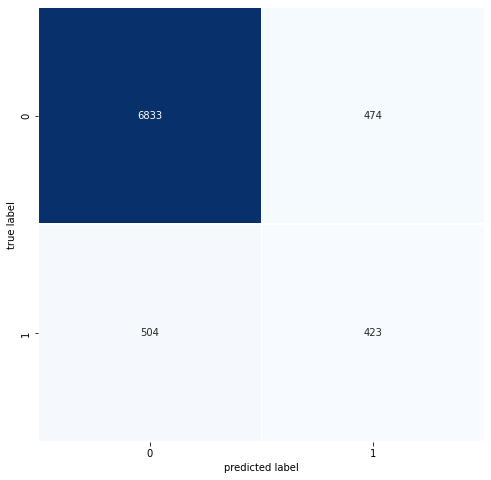

In [37]:
plot_confusion_matrix(y_test, preds_50)

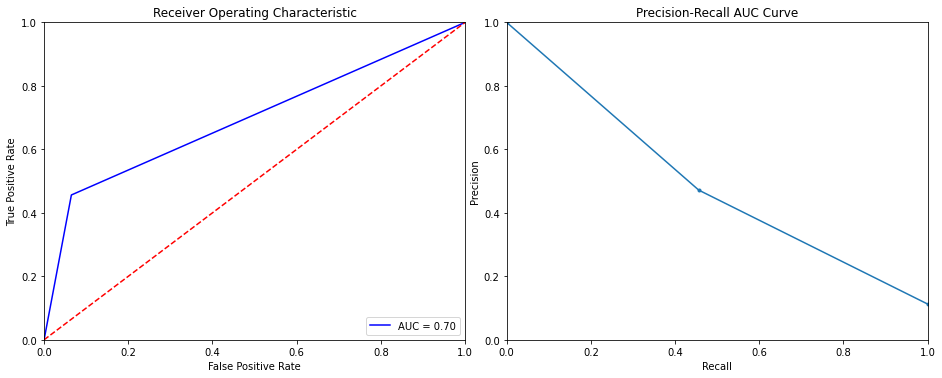

In [38]:
plot_curve(y_test, preds_50)

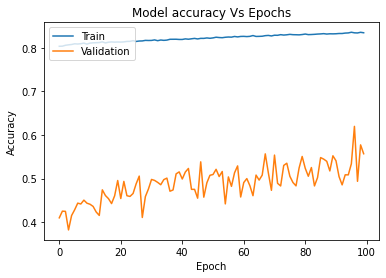

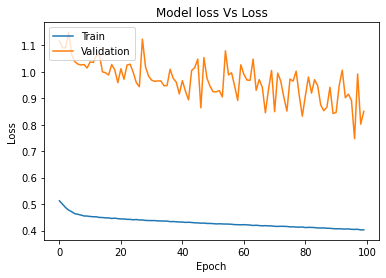

In [39]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
loss, accuracy = model.evaluate(x_test, y_test)

258/258 [==============================] - 1s 3ms/step - loss: 0.3392 - accuracy: 0.8812


### train NN on the dataset by removing unknowns and days-of-week

In [41]:
df_raw_2 = pd.get_dummies(x)

df_raw_2 = df_raw_2.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_2.shape

(41170, 32)

In [42]:
scaler = MinMaxScaler()
x_2 = scaler.fit_transform(df_raw_2)

In [43]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_2, y, test_size = 0.2, random_state=42)
#take out stratify approach
print(x_train2.shape,
      x_test2.shape,
      y_train2.shape,
      y_test2.shape)

(32936, 32) (8234, 32) (32936,) (8234,)


In [44]:
smote = SMOTE()

x_s2, y_s2 = smote.fit_resample(x_train2, y_train2)

print('Original dataset shape', len(x_train2))
print('Resampled dataset shape', len(x_s2))

Original dataset shape 32936
Resampled dataset shape 58454


In [48]:
model2 = Sequential()
model2.add(Flatten(input_shape=( x_s2.shape[1],)))
model2.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model2.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [49]:
model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


In [51]:
model2_history = model2.fit(x_s2, y_s2,validation_split=0.33, batch_size = 100, epochs = 100)

Epoch 1/100
392/392 [==============================] - 2s 6ms/step - loss: 0.4784 - accuracy: 0.8079 - val_loss: 1.1262 - val_accuracy: 0.3727
Epoch 2/100
392/392 [==============================] - 3s 7ms/step - loss: 0.4641 - accuracy: 0.8111 - val_loss: 1.0343 - val_accuracy: 0.4412
Epoch 3/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4592 - accuracy: 0.8112 - val_loss: 1.1275 - val_accuracy: 0.4178
Epoch 4/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.8121 - val_loss: 1.0380 - val_accuracy: 0.4595
Epoch 5/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4545 - accuracy: 0.8129 - val_loss: 0.9467 - val_accuracy: 0.5127
Epoch 6/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4519 - accuracy: 0.8128 - val_loss: 0.9512 - val_accuracy: 0.4857
Epoch 7/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4491 - accuracy: 0.8134 - val_loss: 1.0401 - val_accuracy: 0.4793

In [57]:
preds_2 = model2.predict(x_test2)
preds_2 =  [1 if i>0.5 else 0 for i in preds_2]

In [59]:
print_validation_report(y_test2, preds_2)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7307
           1       0.43      0.52      0.47       927

    accuracy                           0.87      8234
   macro avg       0.69      0.72      0.70      8234
weighted avg       0.88      0.87      0.87      8234

Accuracy Score: 0.8690794267670634
Kappa-  0.3986025698372926
F1-  0.4726027397260274
ROC_AUC_score-  0.7171347420104762
PR AUC-  0.27922284360118194


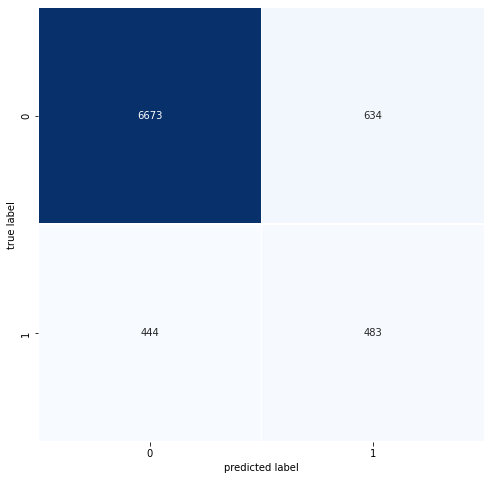

In [61]:
plot_confusion_matrix(y_test2, preds_2)

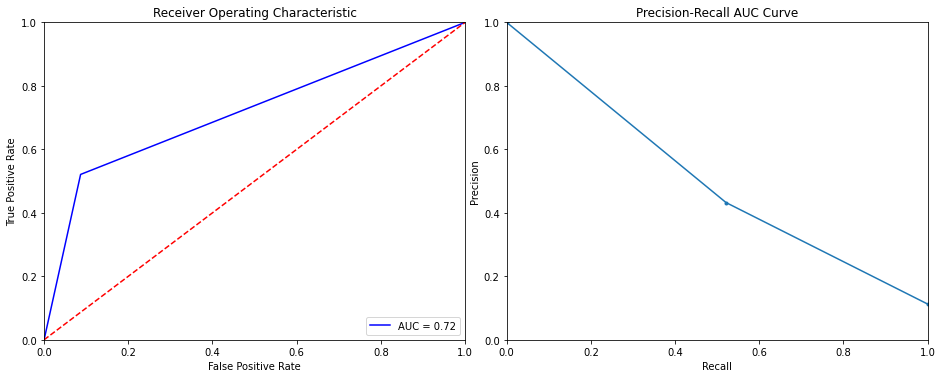

In [62]:
plot_curve(y_test2, preds_2)

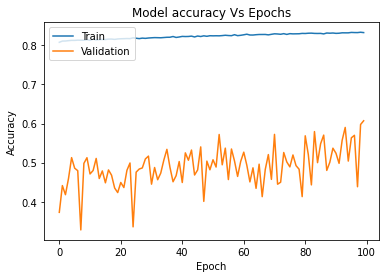

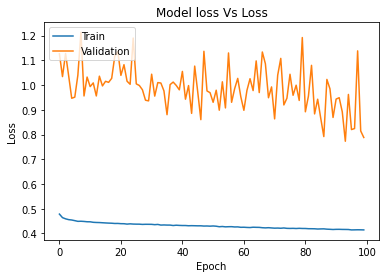

In [63]:
plt.plot(model2_history.history['accuracy'])
plt.plot(model2_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###Train the model with duration feature - comparison purpose

In [ ]:
data_dur = data_1.copy()

In [ ]:
df_dur = data_dur[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [ ]:
y = df_dur['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

In [ ]:
x = df_dur.drop('y', axis=1)

In [ ]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [ ]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_3.shape

(41170, 33)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_3 = scaler.fit_transform(df_raw_3)

In [ ]:
x_3

array([[0.48148148, 0.05307035, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.03029687, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.04595364, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.03843026, 0.01818182, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.08987393, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.7037037 , 0.04859699, 0.03636364, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(x_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32936, 33) (8234, 33) (32936,) (8234,)


In [ ]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32936
Resampled dataset shape 58454


In [ ]:
y_s3.value_counts()

0    29227
1    29227
Name: y, dtype: int64

In [ ]:
model3 = Sequential()
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s3.shape[1]))
model3.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [ ]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                544       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7890 - val_loss: 0.9856 - val_accuracy: 0.4475
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4224 - accuracy: 0.8160 - val_loss: 0.8085 - val_accuracy: 0.5251
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3583 - accuracy: 0.8400 - val_loss: 0.6859 - val_accuracy: 0.6417
Epoch 4/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3228 - accuracy: 0.8588 - val_loss: 0.6096 - val_accuracy: 0.7239
Epoch 5/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3100 - accuracy: 0.8656 - val_loss: 0.6349 - val_accuracy: 0.7250
Epoch 6/100
3917/3917 [==============================] - 10s 3ms/step - loss: 0.3033 - accuracy: 0.8698 - val_loss: 0.5197 - val_accuracy: 0.8158
Epoch 7/100
3917/3917 [==============================] - 8s 2ms/step - loss: 0.2993 - accuracy: 0.8706 - val_loss: 0.6350 - val_a

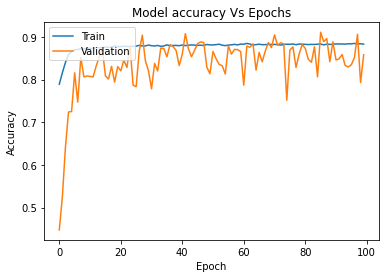

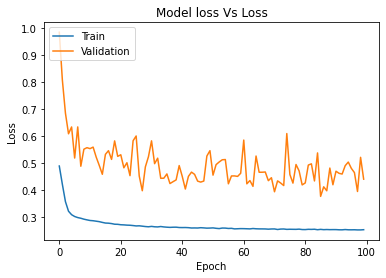

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model3.evaluate(x_test3, y_test3)

258/258 [==============================] - 1s 4ms/step - loss: 0.2146 - accuracy: 0.8911


In [ ]:
preds3 = model3.predict(x_test3)
preds3=np.argmax(preds3, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [ ]:
print_validation_report(y_test3, preds3)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Root Mean Square Error: 0.33553237871752506


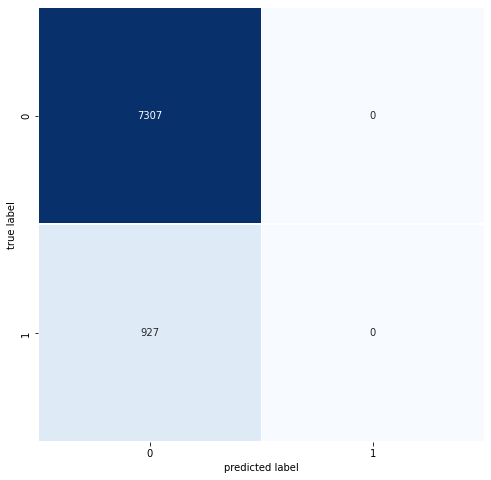

In [ ]:
plot_confusion_matrix(y_test3,preds3)

### Train NN based on original dataset for comparison purpose without duration

In [64]:
data_2 = data.copy()
df_tran_2 = data_2.drop(['duration'], axis=1)
df_tran_2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [65]:
y = df_tran_2['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [66]:
x = df_tran_2.drop('y', axis=1)

In [67]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_s

In [68]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['job_unknown','marital_unknown','education_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1)
df_raw_3.shape

(41188, 56)

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw_3 = scaler.fit_transform(df_raw_3)

In [70]:
df_raw_3

array([[0.48148148, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.01818182, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33333333, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.7037037 , 0.03636364, 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [71]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(df_raw_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32950, 56) (8238, 56) (32950,) (8238,)


In [72]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32950
Resampled dataset shape 58476


In [73]:
model3 = Sequential()
model3.add(Flatten(input_shape=( x_s3.shape[1],)))
model3.add(Dense(units = 64, kernel_initializer = 'he_uniform',activation='relu'))
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [74]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                3648      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________________________


In [75]:
model3_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 100, epochs = 100)

Epoch 1/100
392/392 [==============================] - 6s 10ms/step - loss: 0.7030 - accuracy: 0.7544 - val_loss: 1.2525 - val_accuracy: 0.3403
Epoch 2/100
392/392 [==============================] - 3s 7ms/step - loss: 0.5437 - accuracy: 0.8036 - val_loss: 1.1400 - val_accuracy: 0.4307
Epoch 3/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4961 - accuracy: 0.8105 - val_loss: 1.0124 - val_accuracy: 0.4955
Epoch 4/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4750 - accuracy: 0.8111 - val_loss: 1.1058 - val_accuracy: 0.4484
Epoch 5/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4631 - accuracy: 0.8126 - val_loss: 1.0172 - val_accuracy: 0.4962
Epoch 6/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.8132 - val_loss: 1.1322 - val_accuracy: 0.4520
Epoch 7/100
392/392 [==============================] - 1s 3ms/step - loss: 0.4516 - accuracy: 0.8156 - val_loss: 0.9833 - val_accuracy: 0.504

In [76]:
preds_3 = model3.predict(x_test3)
preds_3 =  [1 if i>0.5 else 0 for i in preds_3]

In [77]:
print_validation_report(y_test3, preds_3)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7310
           1       0.53      0.41      0.46       928

    accuracy                           0.89      8238
   macro avg       0.73      0.68      0.70      8238
weighted avg       0.88      0.89      0.89      8238

Accuracy Score: 0.8932993445010925
Kappa-  0.40622669683146606
F1-  0.4643510054844607
ROC_AUC_score-  0.6825715540827397
PR AUC-  0.28578739750193977


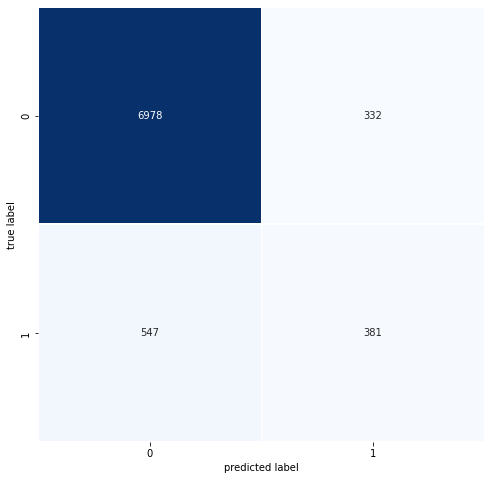

In [78]:
plot_confusion_matrix(y_test3, preds_3)

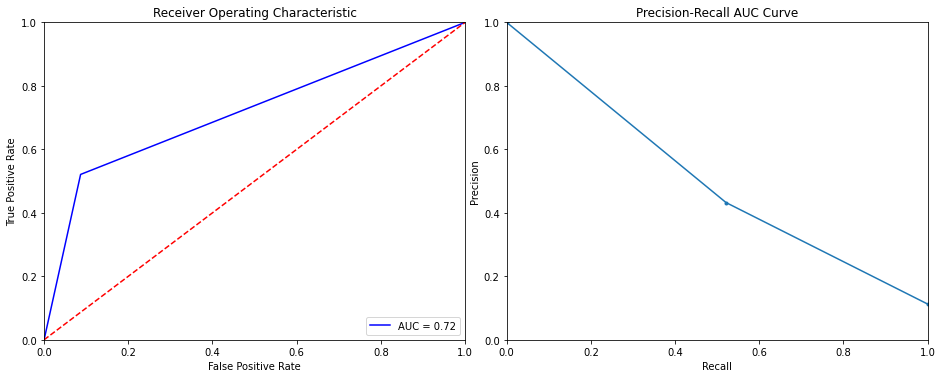

In [ ]:
plot_curve(y_test3, preds_3)

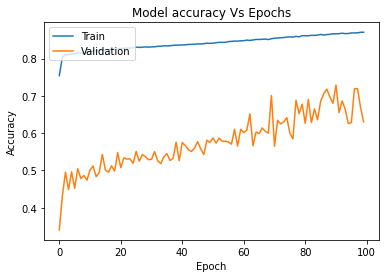

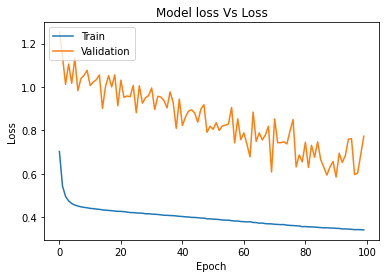

In [79]:
plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()